In [1]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [2]:
! ls

drive  sample_data


# **Importing the required libraries**

In [3]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
!pip install torchvision
import torch
from torch import nn
from torch import optim
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as TF

import random
import os, shutil
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

! pip install transformers
! pip install ml_collections
! pip install torchinfo

'''! 7z x "/content/drive/MyDrive/Hand Segmentation/train.zip" -o./dataset/train '-xr!__MACOSX'
! 7z x "/content/drive/MyDrive/Hand Segmentation/test.zip" -o./dataset/test '-xr!__MACOSX'
! mv dataset/train/train/* dataset/train/ && rm -rf dataset/train/train
! mv dataset/test/test/* dataset/test/ && rm -rf dataset/test/test
! cp "/content/drive/MyDrive/Hand Segmentation/sample_submission.csv" sample_submission.csv

! git clone https://github.com/adast/TransResUNet
! wget https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz
'''
%matplotlib inline

import torchvision
torchvision.__version__

     |████████████████████████████████| 3.4 MB 7.3 MB/s 
     |████████████████████████████████| 61 kB 695 kB/s 
     |████████████████████████████████| 596 kB 57.0 MB/s 
     |████████████████████████████████| 3.3 MB 61.7 MB/s 
     |████████████████████████████████| 895 kB 73.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 88 kB 5.8 MB/s 


'0.11.1+cu111'

In [4]:
!ls drive/MyDrive/Tranresunet/

kaggle_3m  R50+ViT-B_16.npz  R50+ViT-L_32.npz  TranResunet.ipynb  TransResUNet



# **Setup Config class**

In [5]:
MODEL_TYPE = "UNET"
# MODEL_TYPE = "DEFORMABLE_UNET"
LOSS = "CE"
# LOSS = "DICE"
IN_SIZE = (64, 64) #OVERRIDES THE CONFIG

class Config:   
    # data preprocessing
    data_dir = '/content/drive/My Drive/Tranresunet/kaggle_3m/'
    logdir = 'logdir'
    validation_fraction = 0.15
    test_fraction = 0.10
    train_batch = 16
    valid_batch = 32
    test_batch = 32
    
    # model setup
    input_dim = 256
    input_ch = 3
    output_dim = 256
    output_ch = 1
    
    # training
    seed = 21
    learning_rate = 3e-4
    epochs = 30
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# **Helper functions**

In [6]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
def plot_example(idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])
    img = Image.open(img_path)
    mask = Image.open(mask_path)

    fig, ax = plt.subplots(1, 2, figsize=(8,4))
    ax[0].imshow(img)
    ax[0].set_title('Image')
    ax[1].imshow(mask) 
    ax[1].set_title('Mask')
    plt.show()
    
def show_sample(sample, title=None):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(sample[0])
    ax[1].imshow(sample[1], cmap='gray')
    if title:
        fig.suptitle(title)
    plt.show()
    
def plot_predictions(model, idx):
    base_path = os.path.join(Config.data_dir, test_df['directory'].iloc[idx])
    img_path = os.path.join(base_path, test_df['images'].iloc[idx])
    mask_path = os.path.join(base_path, test_df['masks'].iloc[idx])

    img = Image.open(img_path)
    mask = Image.open(mask_path)

    tensor_img, tensor_mask = eval_transforms((img, mask))
    tensor_img = tensor_img.unsqueeze(0).to(Config.device) 
    
    model.eval()
    with torch.no_grad():
        pred = model(tensor_img)[0].detach().cpu().numpy()
        pred = pred.transpose((1, 2, 0)).squeeze()
        rounded = np.round(pred)
    
    plot_images = {'Image': img, 
                   'Mask': mask, 
                   'Predicted Mask': pred, 
                   'Predicted Rounded Mask': rounded}

    fig, ax = plt.subplots(1, 4, figsize=(16,4))
    for i, key in enumerate(plot_images.keys()):
        ax[i].imshow(plot_images[key])
        ax[i].set_title(key)
    plt.show()
    
set_seed(Config.seed)

# **Loading and exploring the data**

In [7]:
dirs, images, masks = [], [], []
for root, folders, files in os.walk(Config.data_dir):
    for file in files:
        # save only images with corresponding masks
        if 'mask'in file:
            dirs.append(root.replace(Config.data_dir, ''))
            masks.append(file)
            images.append(file.replace('_mask', ''))

PathDF = pd.DataFrame({'directory': dirs, 'images': images, 'masks': masks})
PathDF.head()

,directory,images,masks
0,TCGA_HT_8114_19981030,TCGA_HT_8114_19981030_11.tif,TCGA_HT_8114_19981030_11_mask.tif
1,TCGA_HT_8114_19981030,TCGA_HT_8114_19981030_10.tif,TCGA_HT_8114_19981030_10_mask.tif
2,TCGA_HT_8114_19981030,TCGA_HT_8114_19981030_17.tif,TCGA_HT_8114_19981030_17_mask.tif
3,TCGA_HT_8114_19981030,TCGA_HT_8114_19981030_1.tif,TCGA_HT_8114_19981030_1_mask.tif
4,TCGA_HT_8114_19981030,TCGA_HT_8114_19981030_18.tif,TCGA_HT_8114_19981030_18_mask.tif


## **Train, test and validation split**

In [8]:
train2rest = Config.validation_fraction + Config.test_fraction
test2valid = Config.validation_fraction/train2rest

train_df, rest = train_test_split(
    PathDF, random_state=Config.seed,
    test_size=train2rest
)

test_df, valid_df = train_test_split(
    rest, random_state=Config.seed,
    test_size=test2valid
)

print('Train:', train_df.shape[0])
print('Valid:', valid_df.shape[0])
print('Test:', test_df.shape[0])

Train: 1547
Valid: 310
Test: 206


# **Visualization of the images and the masks**

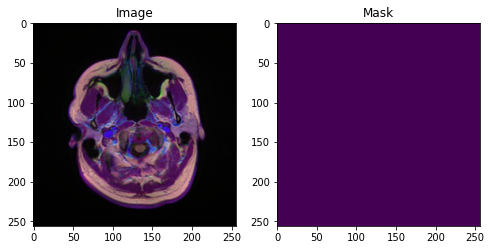

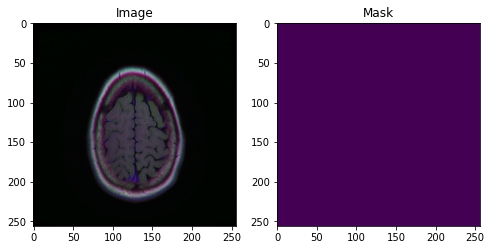

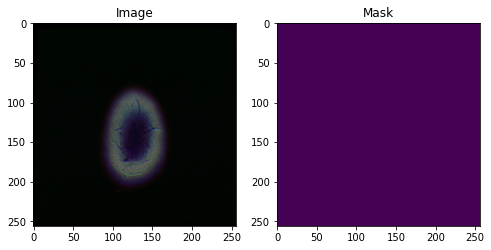

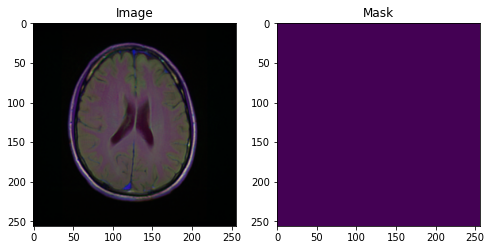

In [9]:
plot_example(69)
plot_example(123)
plot_example(24)
plot_example(34)

# **Dataset class**

In [10]:
class MRI_Dataset(Dataset):
    def __init__(self, path_df, transform=None):
        self.path_df = path_df
        self.transform = transform

    def __len__(self):
        return self.path_df.shape[0]

    def __getitem__(self, idx):
        base_path = os.path.join(Config.data_dir, self.path_df.iloc[idx]['directory'])
        img_path = os.path.join(base_path, self.path_df.iloc[idx]['images'])
        mask_path = os.path.join(base_path, self.path_df.iloc[idx]['masks'])

        image = Image.open(img_path)
        mask = Image.open(mask_path)

        sample = (image, mask)
        # apply the same transform on both image and a mask
        if self.transform:
            sample = self.transform(sample)

        return sample

# **Custom Transformations**

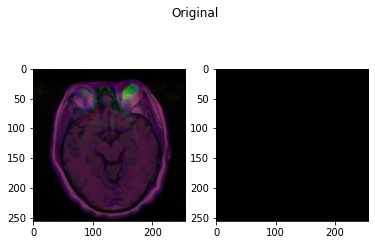

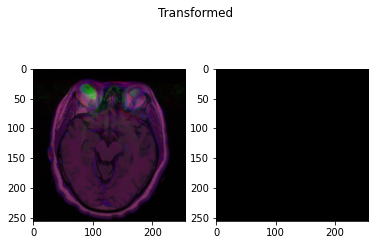

In [11]:
from PIL import Image


class PairedRandomHorizontalFlip():
    """Custom transform for horizontal flipping"""
    def __init__(self, prob=0.5):
        self.prob = prob   

    def __call__(self, sample):
        """
        Randomly flips both of the images

        Arguments:
        sample - tuple, image and segmentation mask
    
        Returns:
        (img, mask) - tuple, transformed sample
        """
        img, mask = sample
        if np.random.random() < self.prob:
            img, mask = TF.hflip(img), TF.hflip(mask)
        return img, mask
    
class PairedRandomAffine():
    """
    Randomly applies affine transformation
    on both of the images
    """
    def __init__(self, degrees=None, translate=None, scale_ranges=None, shears=None):

        self.params = {
            'degrees': degrees,
            'translate': translate,
            'scale_ranges': scale_ranges,
            'shears': shears
        }

    def __call__(self, sample):
        img, mask = sample
        w, h = img.size
        # extract parameters from trasnforms.RandomAffine
        angle, translations, scale, shear = transforms.RandomAffine.get_params(self.params['degrees'], self.params['translate'], self.params['scale_ranges'], self.params['shears'], (w,h))
        # apply TF.affine using fixed parameters
        img = TF.affine(img, angle, translations, scale, shear)
        mask = TF.affine(mask, angle, translations, scale, shear)
        return img, mask
    
class Resize():
    """
    Resize
    """
    def __init__(self, size=IN_SIZE):
        self.size = size
        self.resize = torchvision.transforms.Resize(size, interpolation=Image.NEAREST)
        
        
    def __call__(self, sample):
        img, mask = sample
        # extract parameters from trasnforms.RandomAffine
        img = self.resize(img)
        mask = self.resize(mask)
        return img, mask
    
class PairedToTensor():
    """
    Convert ndarrays in sample to Tensors.
    """
    def __call__(self, sample):
        img, mask = sample
        img = np.array(img)
        mask = np.expand_dims(mask, -1)
        img = np.moveaxis(img, -1, 0)
        mask = np.moveaxis(mask, -1, 0)
        img, mask =  torch.FloatTensor(img), torch.FloatTensor(mask)
        img = img/255
        mask = mask/255
        return img, mask
    
dataset = MRI_Dataset(test_df)
sample = dataset[59]
transform = PairedRandomHorizontalFlip(prob=1)
show_sample(sample, title='Original')
show_sample(transform(sample), title='Transformed')

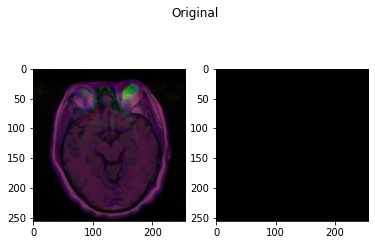

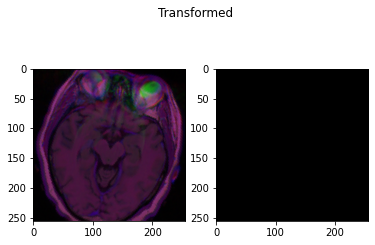

In [12]:
transform = PairedRandomAffine(
    degrees=(15, 15),
    scale_ranges=(1.2, 1.2)
) # for testing purposes we fix degrees and scale to a constant number
show_sample(sample, 'Original')
show_sample(transform(sample), 'Transformed')

# **Data transformation and loaders**

In [13]:
train_transforms = transforms.Compose([                       
    PairedRandomHorizontalFlip(), 
    PairedRandomAffine(
        degrees=(-15, 15),
        translate=(0.1, 0.1),
        scale_ranges=(0.8, 1.2)
    ),
    Resize(IN_SIZE),
    PairedToTensor()
])
eval_transforms = transforms.Compose([                       
    Resize(IN_SIZE),
    PairedToTensor()
])

train_data = MRI_Dataset(train_df, transform=train_transforms)
valid_data = MRI_Dataset(valid_df, transform=eval_transforms)
test_data = MRI_Dataset(test_df, transform=eval_transforms)

train_loader = DataLoader(train_data, batch_size=Config.train_batch, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_data, batch_size=Config.valid_batch, shuffle=False, num_workers=0)
test_loader = DataLoader(test_data, batch_size=Config.test_batch, shuffle=False, num_workers=0)

/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


# **Define the model**

In [14]:
import torch
import torchvision.ops
from torch import nn

class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 bias=False):

        super(DeformableConv2d, self).__init__()
        
        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        
        self.offset_conv = nn.Conv2d(in_channels, 
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)
        
        self.modulator_conv = nn.Conv2d(in_channels, 
                                     1 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size, 
                                     stride=stride,
                                     padding=self.padding, 
                                     bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)
        
        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      bias=bias)

    def forward(self, x):
        #h, w = x.shape[2:]
        #max_offset = max(h, w)/4.

        offset = self.offset_conv(x)#.clamp(-max_offset, max_offset)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        
        x = torchvision.ops.deform_conv2d(input=x, 
                                          offset=offset, 
                                          weight=self.regular_conv.weight, 
                                          bias=self.regular_conv.bias, 
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          )
        return x
    

In [15]:
class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential( 
            conv(in_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            conv(out_ch, out_ch, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
         )
    def forward(self, x):
        x = self.conv(x)
#         print("Double conv output: ", x.shape)
        return x

In [16]:
class InConv(nn.Module):
    def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
        super(InConv, self).__init__()
        self.conv = DoubleConv(in_ch, out_ch, conv=conv)
    def forward(self, x):
        x = self.conv(x)
#         print("InConv conv output: ", x.shape)
        return x

In [17]:
class Down(nn.Module):
    def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
        super(Down, self).__init__()
        self.mpconv = nn.Sequential( 
            nn.MaxPool2d(2,2),
            DoubleConv(in_ch, out_ch, conv=conv)
         )
    def forward(self, x):
        x = self.mpconv(x)
#         print("Down conv output: ", x.shape)
        return x

In [18]:
class Up(nn.Module):
    def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_ch // 2, in_ch // 2, kernel_size=2, stride=2)
        self.conv = DoubleConv(in_ch, out_ch, conv=conv)
    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
#         print("Up conv output: ", x.shape)
        return x

In [19]:
# class OutConv(nn.Module):
#     def __init__(self, in_ch, out_ch, conv=nn.Conv2d):
#         super(OutConv, self).__init__()
#         self.conv = conv(in_ch, out_ch, 1, padding=0)
#         self.sigmoid = nn.Sigmoid()
#     def forward(self, x):
#         x = self.conv(x)
#         x = self.sigmoid(x)
# #         print("OutConv conv output: ", x.shape)
#         return x

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels, conv=nn.Conv2d):
        super(OutConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=1),
            nn.Sigmoid())
    def forward(self, x):
        return self.conv(x)

In [20]:
class UNet(nn.Module):
    def __init__(self, in_channels, num_classes, conv=nn.Conv2d):
        super(UNet, self).__init__()
        self.inc = InConv(in_channels, 64, conv=conv)
        self.down1 = Down(64, 128, conv=conv)
        self.down2 = Down(128, 256, conv=conv)
        self.down3 = Down(256, 512, conv=conv)
        self.down4 = Down(512, 512, conv=conv)
        self.up1 = Up(1024, 256, conv=conv)
        self.up2 = Up(512, 128, conv=conv)
        self.up3 = Up(256, 64, conv=conv)
        self.up4 = Up(128, 64, conv=conv)
        self.outc = OutConv(64, num_classes, conv=conv)
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [21]:
!ls drive/MyDrive

 1009997.pdf
'11 2019-- DevTest server.gsheet'
 20140929_201622.jpg
 20141019_105255.jpg
 20141226_151128.jpg
 20150912_222005.jpg
 20151029_211834.jpg
 20160314_192232.jpg
 20160314_192528.jpg
'20160327_190051 (1).jpg'
 20160327_190051.jpg
 20171029_173918.jpg
 269_Brainstorm.gdoc
 AMR_research.gdoc
 asalam_project.gdoc
 asalam_project.pdf
'AttendaNCE qUARK.gsheet'
'BI_Tool Eval.gdoc'
'BLOTTO ASSIGNMENT.gdoc'
'California Plan.gsheet'
'CallABus_final_submission.zip (Unzipped Files)'
 Chandra_Nischal.pdf
 cipher_take_home.py
'Colab Notebooks'
'Comapnies Data Forums.gsheet'
 COMEDK.htm
'Companies List.gdoc'
'Companies to Apply.gdoc'
'Copy of Links to PyTorch Colab Notebooks.gdoc'
'Copy of Links to PyTorch VIP Notebooks.gdoc'
'Copy of Untitled form.gform'
 cover.docx
'desert (1).jpg'
 desert.jpg
'desktop (1).ini'
 desktop.ini
 dood.java
'DSC_0213 (1).JPG'
 DSC_0213.JPG
'DSC_0214 (1).JPG'
 DSC_0214.JPG
'DSC_0215 (1).JPG'
 DSC_0215.JPG
'DSC_0218 (1).JPG'
 DSC_0218.JPG
'DSC_0219 (1).JPG'
 DS

In [22]:
import sys
sys.path.insert(0, 'drive/MyDrive/Tranresunet/TransResUNet')
from models import trans_resunet
from models.trans_resunet import TransResUNet

# Transformers
from transformers import AdamW, get_linear_schedule_with_warmup

# Pytorch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torchinfo import summary

# Others
import ml_collections
import os
import glob
import math
import numpy as np
import pandas as pd
import random
from tqdm.notebook import tqdm
from PIL import Image

# Make computations repeatable
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Compute on gpu if available
device = "cuda" if torch.cuda.is_available() else "cpu"





EPOCHS = 30
LEARNING_RATE = 5e-5

def get_r50_b16_config():
    config = ml_collections.ConfigDict()
    
    config.image_size = (64, 64)
    config.n_classes = 1
    #config.pre_trained_path = ''
    config.resnet = ml_collections.ConfigDict()
    # Using three bottleneck blocks results in a downscaling of 2^(1 + 3)=16 which
    # results in an effective patch size of /16.
    config.resnet.num_layers = (3, 4, 9)
    config.resnet.width_factor = 1
    
    config.transformer = ml_collections.ConfigDict()
    config.transformer.num_special_tokens = 1
    config.transformer.patch_size = 16
    config.transformer.hidden_size = 768
    config.transformer.mlp_dim = 3072
    config.transformer.num_heads = 12
    config.transformer.num_layers = 12
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    
    config.decoder = ml_collections.ConfigDict()
    config.decoder.head_channels = 512
    
    return config

def get_r50_l32_config():
    """Returns the ViT-L/32 configuration."""
    config = ml_collections.ConfigDict()
    
    config.image_size = (64, 64)
    config.n_classes = 1
    #config.pre_trained_path = ''
    
    config.resnet = ml_collections.ConfigDict()
    # Using four bottleneck blocks results in a downscaling of 2^(1 + 4)=32 which
    # results in an effective patch size of /32.
    config.resnet.num_layers = (3, 4, 6, 3)
    config.resnet.width_factor = 1
    
    config.transformer = ml_collections.ConfigDict()
    config.transformer.num_special_tokens = 1
    config.transformer.patch_size = 32
    config.transformer.hidden_size = 1024
    config.transformer.mlp_dim = 4096
    config.transformer.num_heads = 16
    config.transformer.num_layers = 24
    config.transformer.attention_dropout_rate = 0.0
    config.transformer.dropout_rate = 0.1
    
    config.decoder = ml_collections.ConfigDict()
    config.decoder.head_channels = 512
    
    return config

config = get_r50_b16_config()
model = TransResUNet(config)
model.to(device)

# Loss and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer, 
    num_warmup_steps = len(train_loader),
    num_training_steps = total_steps
)

pre_trained_path is not specified, use this model with torch.load_state_dict only!


# **Train loop**

In [23]:
def train_loop(model, optimizer, criterion, train_loader, device=Config.device):
    running_loss = 0
    model.train()
    pbar = tqdm(train_loader, desc='Iterating over train data')
    for imgs, masks in pbar:
        # pass to device
        imgs = imgs.to(device)
        masks = masks.to(device)
        # forward
        out = model(imgs)
#         print("imgs: ", imgs.shape)
#         print("masks: ", masks.shape)
#         print("out: ", out.shape)
        #print(out)
        loss = criterion(out, masks)
        running_loss += loss.item()*imgs.shape[0] 
        # optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    running_loss /= len(train_loader.sampler)
    return running_loss

# **Evaluation loop**

In [24]:
def dice_coef_metric(inputs, target):
    intersection = 2.0 * (target * inputs).sum()
    union = target.sum() + inputs.sum()
    if target.sum() == 0 and inputs.sum() == 0:
        return 1.0
    return intersection / union


def iou_metric(inputs, target):
    intersection = np.logical_and(inputs, target)
    union = np.logical_or(inputs, target)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score

In [25]:
def eval_loop(model, criterion, eval_loader, device=Config.device):
    global labelsx
    running_loss = 0
    model.eval()
    with torch.no_grad():
        accuracy, f1_scores = [], []
        dices, ious = [], []
        pbar = tqdm(eval_loader, desc='Iterating over evaluation data')
        for imgs, masks in pbar:
            # pass to device
            imgs = imgs.to(device)
            masks = masks.to(device)
            # forward
            out = model(imgs)
            loss = criterion(out, masks)
            running_loss += loss.item()*imgs.shape[0]
            # calculate predictions using output
            predicted = (out > 0.5).float()
            predicted = predicted.view(-1).cpu().numpy()
            labels = masks.view(-1).cpu().numpy()
            accuracy.append(accuracy_score(labels, predicted))
            f1_scores.append(f1_score(labels, predicted))
            dices.append(dice_coef_metric(labels, predicted))
            ious.append(iou_metric(labels, predicted))
    acc = sum(accuracy)/len(accuracy)
    f1 = sum(f1_scores)/len(f1_scores)
    dice = sum(dices)/len(dices)
    iou = sum(ious)/len(ious)
    running_loss /= len(eval_loader.sampler)
    return {
        'accuracy':acc,
        'f1_macro':f1, 
        'loss':running_loss,
        'dice': dice,
        'iou': iou,
    }

# **Train the model**

In [26]:
def train(model, optimizer, criterion, train_loader, valid_loader,
          device=Config.device, 
          num_epochs=Config.epochs, 
          valid_loss_min=np.inf):
    
    for e in range(num_epochs):
        # train for epoch
        train_loss = train_loop(
            model, optimizer, criterion, train_loader, device=device)
        # evaluate on validation set
        metrics = eval_loop(
            model, criterion, valid_loader, device=device
        )
        # show progress
        print_string = f'Epoch: {e+1} '
        print_string+= f'TrainLoss: {train_loss:.5f} '
        print_string+= f'ValidLoss: {metrics["loss"]:.5f} '
        print_string+= f'ACC: {metrics["accuracy"]:.5f} '
        print_string+= f'F1: {metrics["f1_macro"]:.3f}'
        print_string+= f' Dice: {metrics["dice"]:.3f}'
        print_string+= f' IoU: {metrics["iou"]:.3f}'
        print(print_string)

        # save the model 
        if metrics["loss"] <= valid_loss_min:
            torch.save(model.state_dict(), 'UNet.pt')
            valid_loss_min = metrics["loss"]

In [27]:
def dice(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [28]:
set_seed(Config.seed)
if MODEL_TYPE == "UNET":
    pass
    #model = UNet(Config.input_ch, Config.output_ch).to(Config.device)
if MODEL_TYPE == "DEFORMABLE_UNET":
    model = UNet(Config.input_ch, Config.output_ch, conv=DeformableConv2d).to(Config.device)
optimizer = optim.Adam(model.parameters(), lr=Config.learning_rate)
if LOSS == "CE":
    criterion =  nn.BCEWithLogitsLoss()
else:
    criterion = dice

In [29]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

In [30]:
get_n_params(model)

109632065

In [31]:
#344208641

In [32]:
train(model, optimizer, criterion, train_loader, valid_loader)

Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)


Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 TrainLoss: 0.12556 ValidLoss: 0.02537 ACC: 0.99193 F1: 0.574 Dice: 0.574 IoU: 0.408


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 2 TrainLoss: 0.02144 ValidLoss: 0.02075 ACC: 0.99354 F1: 0.694 Dice: 0.694 IoU: 0.536


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 3 TrainLoss: 0.01609 ValidLoss: 0.01620 ACC: 0.99412 F1: 0.722 Dice: 0.722 IoU: 0.570


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 4 TrainLoss: 0.01331 ValidLoss: 0.01255 ACC: 0.99511 F1: 0.789 Dice: 0.789 IoU: 0.654


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 5 TrainLoss: 0.01192 ValidLoss: 0.01220 ACC: 0.99552 F1: 0.808 Dice: 0.808 IoU: 0.679


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 6 TrainLoss: 0.01163 ValidLoss: 0.01149 ACC: 0.99571 F1: 0.820 Dice: 0.820 IoU: 0.696


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 7 TrainLoss: 0.01000 ValidLoss: 0.01099 ACC: 0.99589 F1: 0.838 Dice: 0.838 IoU: 0.722


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 8 TrainLoss: 0.00951 ValidLoss: 0.01006 ACC: 0.99625 F1: 0.844 Dice: 0.844 IoU: 0.733


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 9 TrainLoss: 0.00984 ValidLoss: 0.01017 ACC: 0.99582 F1: 0.818 Dice: 0.818 IoU: 0.694


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 10 TrainLoss: 0.00884 ValidLoss: 0.00967 ACC: 0.99627 F1: 0.846 Dice: 0.846 IoU: 0.735


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 11 TrainLoss: 0.00821 ValidLoss: 0.00888 ACC: 0.99656 F1: 0.861 Dice: 0.861 IoU: 0.757


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 12 TrainLoss: 0.00833 ValidLoss: 0.00947 ACC: 0.99621 F1: 0.842 Dice: 0.842 IoU: 0.729


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 13 TrainLoss: 0.00788 ValidLoss: 0.00885 ACC: 0.99637 F1: 0.847 Dice: 0.847 IoU: 0.737


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 14 TrainLoss: 0.00804 ValidLoss: 0.00903 ACC: 0.99634 F1: 0.849 Dice: 0.849 IoU: 0.739


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 15 TrainLoss: 0.00775 ValidLoss: 0.00826 ACC: 0.99653 F1: 0.854 Dice: 0.854 IoU: 0.746


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 16 TrainLoss: 0.00890 ValidLoss: 0.00949 ACC: 0.99632 F1: 0.848 Dice: 0.848 IoU: 0.738


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 17 TrainLoss: 0.00826 ValidLoss: 0.00897 ACC: 0.99622 F1: 0.838 Dice: 0.838 IoU: 0.723


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 18 TrainLoss: 0.00818 ValidLoss: 0.00788 ACC: 0.99682 F1: 0.870 Dice: 0.870 IoU: 0.770


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 19 TrainLoss: 0.00725 ValidLoss: 0.00811 ACC: 0.99686 F1: 0.873 Dice: 0.873 IoU: 0.776


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 20 TrainLoss: 0.00701 ValidLoss: 0.00849 ACC: 0.99668 F1: 0.865 Dice: 0.865 IoU: 0.764


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 21 TrainLoss: 0.00716 ValidLoss: 0.00794 ACC: 0.99671 F1: 0.863 Dice: 0.863 IoU: 0.760


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 22 TrainLoss: 0.00674 ValidLoss: 0.00762 ACC: 0.99700 F1: 0.878 Dice: 0.878 IoU: 0.783


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 23 TrainLoss: 0.00669 ValidLoss: 0.00746 ACC: 0.99694 F1: 0.873 Dice: 0.873 IoU: 0.776


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 24 TrainLoss: 0.00665 ValidLoss: 0.00730 ACC: 0.99697 F1: 0.874 Dice: 0.874 IoU: 0.778


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 25 TrainLoss: 0.00637 ValidLoss: 0.00778 ACC: 0.99675 F1: 0.863 Dice: 0.863 IoU: 0.761


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 26 TrainLoss: 0.00664 ValidLoss: 0.00744 ACC: 0.99689 F1: 0.870 Dice: 0.870 IoU: 0.771


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 27 TrainLoss: 0.00700 ValidLoss: 0.00750 ACC: 0.99701 F1: 0.880 Dice: 0.880 IoU: 0.787


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 28 TrainLoss: 0.00645 ValidLoss: 0.00706 ACC: 0.99715 F1: 0.887 Dice: 0.887 IoU: 0.798


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 29 TrainLoss: 0.00616 ValidLoss: 0.00736 ACC: 0.99714 F1: 0.883 Dice: 0.883 IoU: 0.792


Iterating over train data:   0%|          | 0/97 [00:00<?, ?it/s]

Iterating over evaluation data:   0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 30 TrainLoss: 0.00593 ValidLoss: 0.00719 ACC: 0.99712 F1: 0.883 Dice: 0.883 IoU: 0.792


In [33]:
# Load the latest model
model.load_state_dict(torch.load('UNet.pt'))
metrics = eval_loop(model, criterion, train_loader)
print("SEARCH THIS STRING SEARCH SERCH SEARCH")


print('Train accuracy:', metrics['accuracy'])
print('Train f1 macro:', metrics['f1_macro'])
print('Train loss:', metrics['loss'])
print('Train IoU:', metrics['iou'])
print('Train Dice:', metrics['dice'])

metrics = eval_loop(model, criterion, test_loader)
print('Test accuracy:', metrics['accuracy'])
print('Test f1 macro:', metrics['f1_macro'])
print('Test loss:', metrics['loss'])
print('Test IoU:', metrics['iou'])
print('Test Dice:', metrics['dice'])

Iterating over evaluation data:   0%|          | 0/97 [00:00<?, ?it/s]

SEARCH THIS STRING SEARCH SERCH SEARCH
Train accuracy: 0.9976278517775816
Train f1 macro: 0.8737368573892454
Train loss: 0.006081663573289599
Train IoU: 0.7786239721515792
Train Dice: 0.8737368573892454


Iterating over evaluation data:   0%|          | 0/7 [00:00<?, ?it/s]

Test accuracy: 0.9978514690788425
Test f1 macro: 0.8669010370080465
Test loss: 0.006339683963745398
Test IoU: 0.7668530205209069
Test Dice: 0.8669010370080465


# **Visualizing the results**

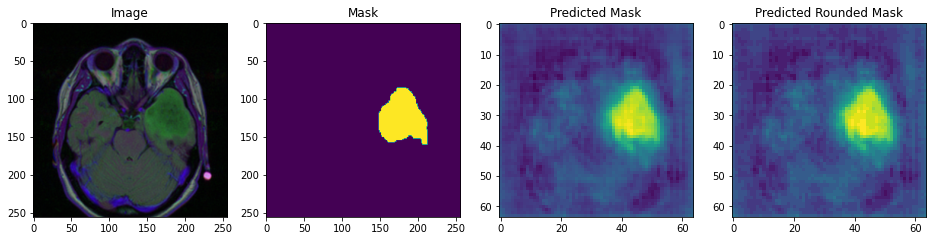

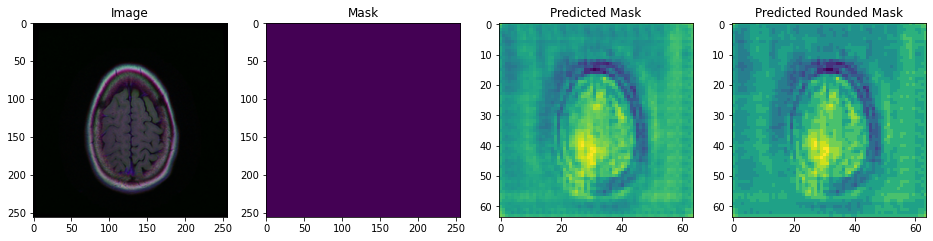

IndexError: ignored

In [35]:
plot_predictions(model, 1)
plot_predictions(model, 123)
plot_predictions(model, 246)
plot_predictions(model, 346)

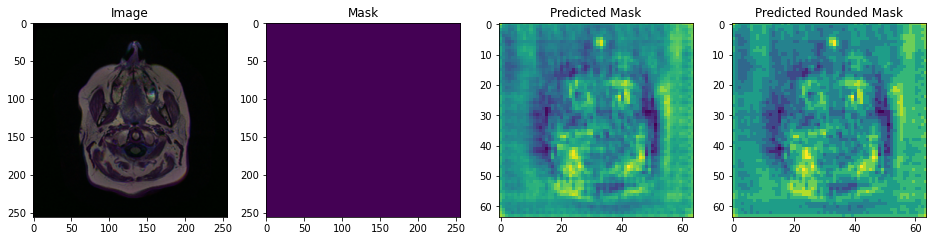

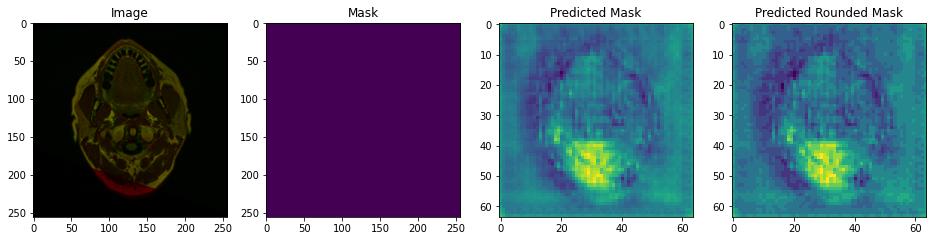

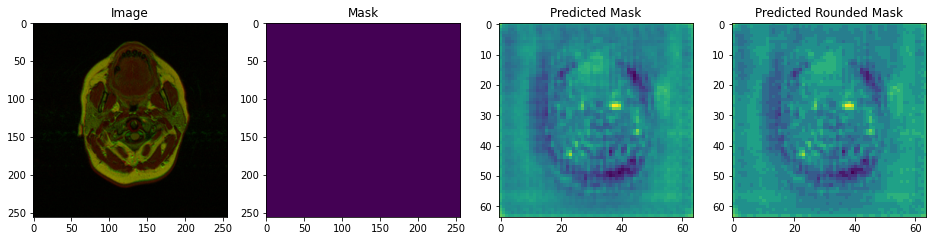

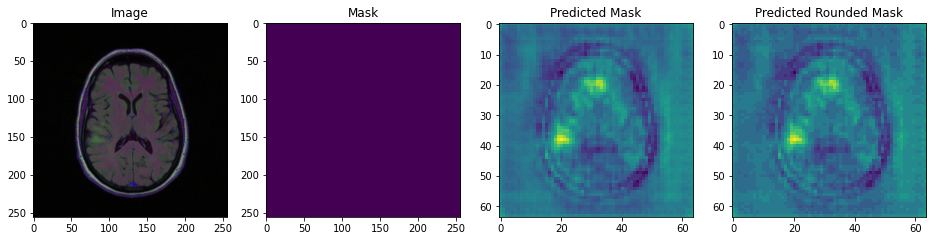

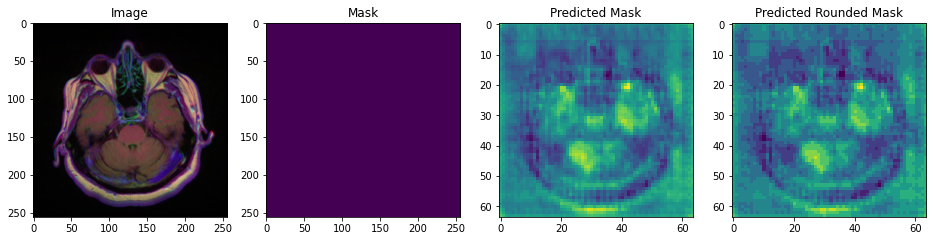

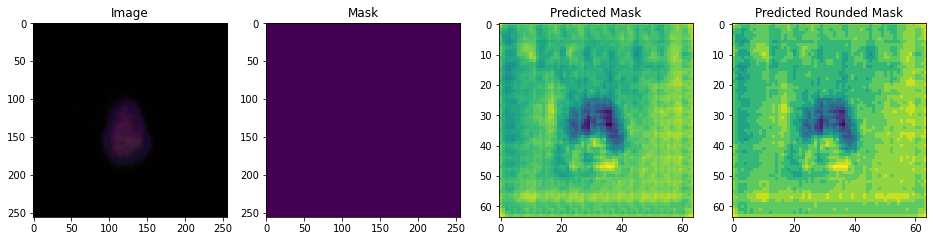

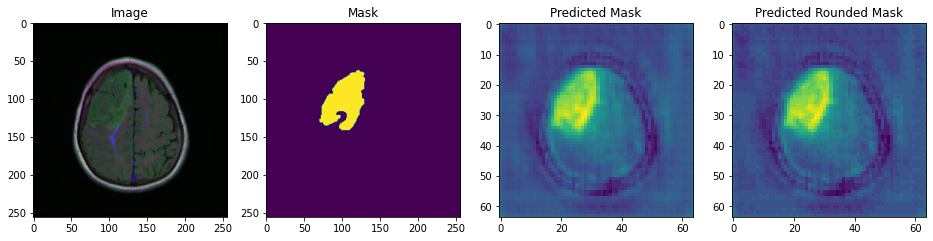

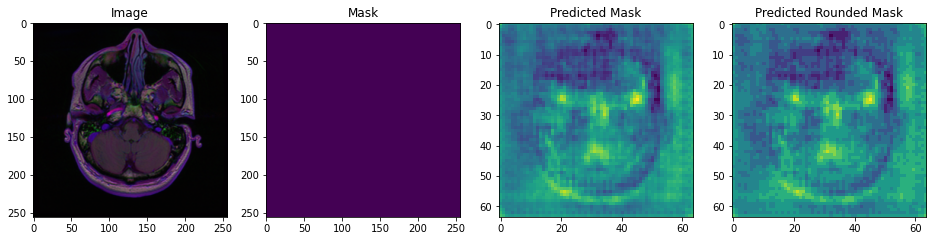

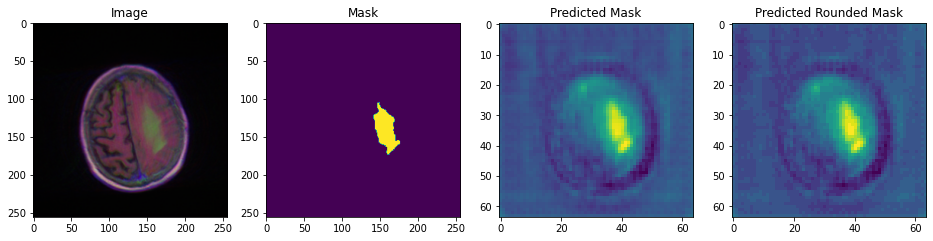

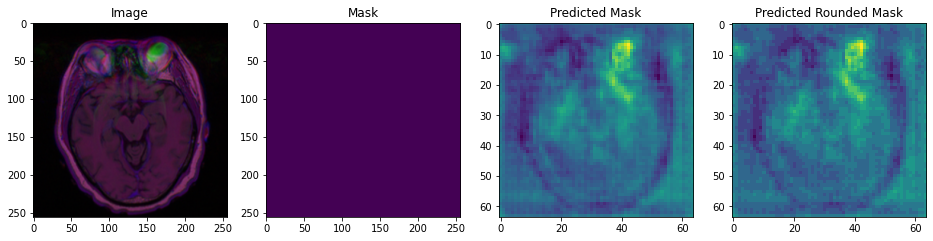

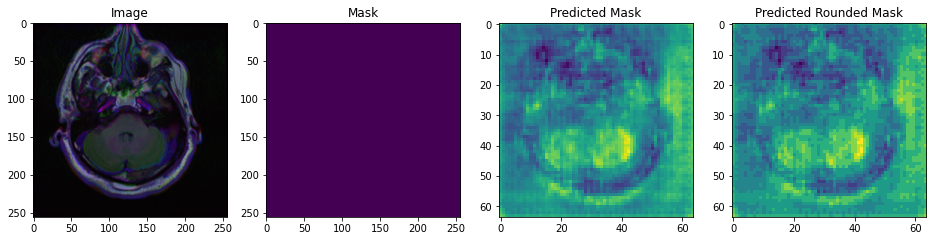

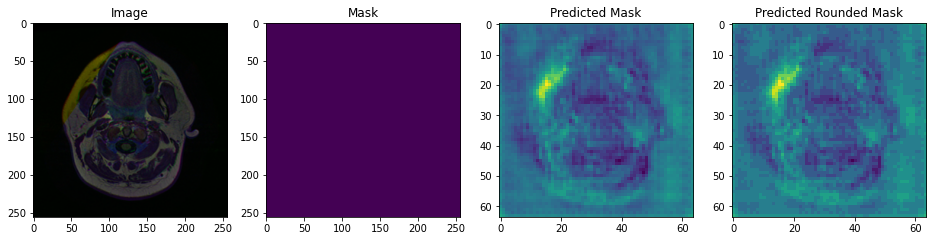

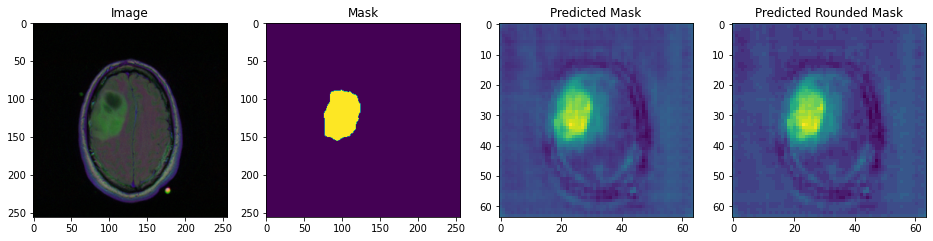

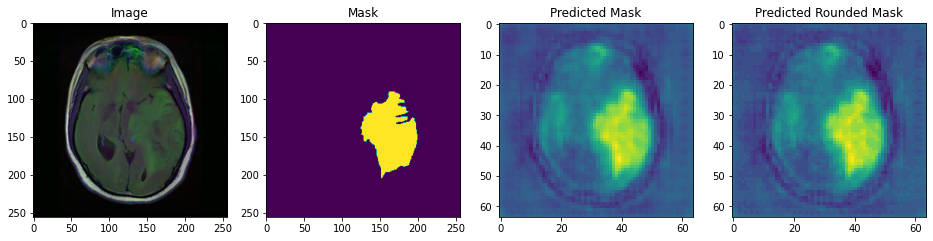

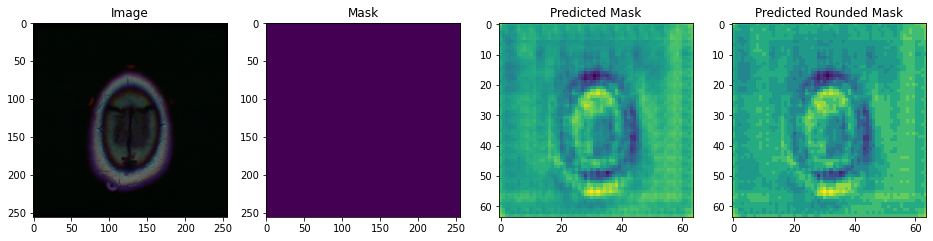

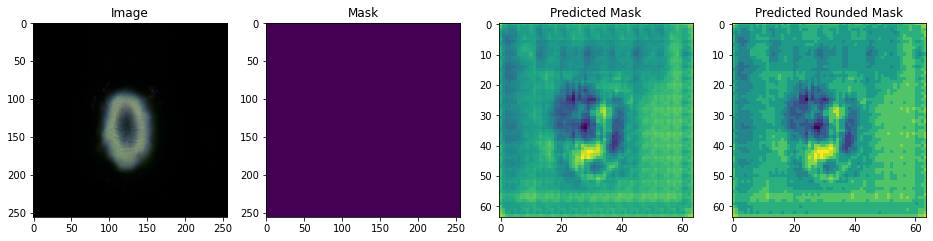

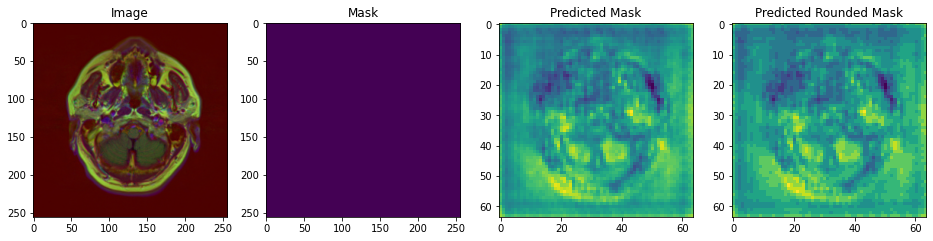

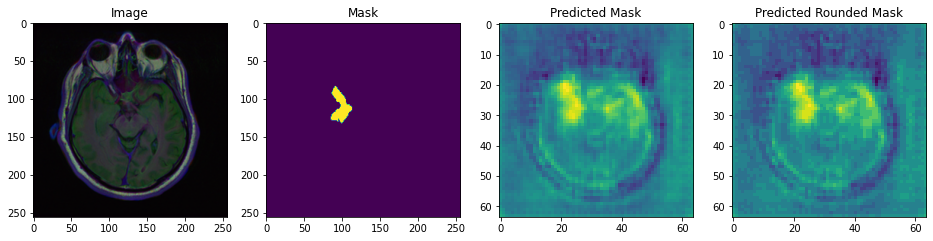

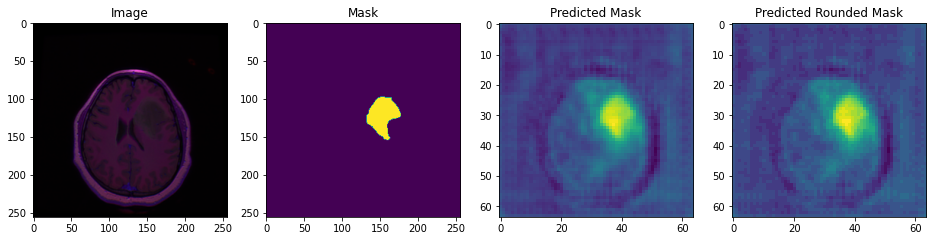

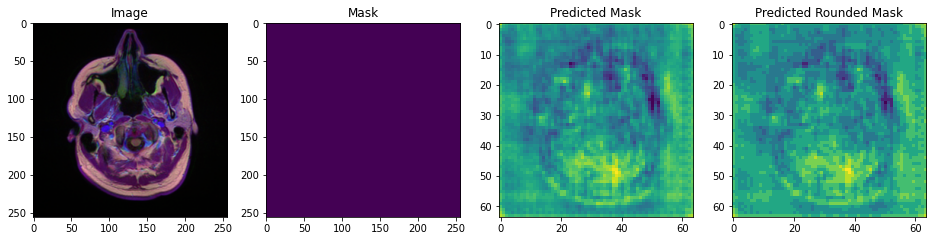

In [36]:
for i in range(50,70):
    plot_predictions(model, i)